# batch analysis of DNA-MERFISH for Aire DNA

by Pu Zheng

2021.10.01


# Load basic functions

In [18]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

43208


# 0. fov parameters

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA',
             'save_folder':r'J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':250,
                     'max_num_seeds': None,
                     'spot_seeding_th': 600,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             'ref_id': 0, # special for this experiment
             }


In [4]:
_overwrite_image = False
fov_ids = np.arange(0,50)
for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ base attributes loaded:['protein_ref_im'] in 1.977s.
+ loading correction from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile dire

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_003.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_003.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_003.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_0

-- folders not selected, allow processing all 26 folders
+ load reference image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_005.dax
- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_005.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_005.dax  in 10.465s
-- removing hot pixels for channels:['561'] in 9.998s
-- correct Z-shifts for channels:['561'] in 8.045s
-- illumination correction for channels: 561, in 3.202s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 32.735s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_005.hdf5
++ base attributes saved:['protein_ref_im'] in 8.314s.
-- checking protein, region:[2 1] in 0.013s.
+ Start sequential pre-processing for 1 images
++ processed protein i

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_006.dax  in 20.750s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 42.859s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 30.950s
-- bleedthrough correction for channels: ['750', '647'] in 12.115s
-- illumination correction for channels: 750, 647, 488, 561, in 13.590s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [ -0.06  -9.15 -38.28] in 5.670s.
-- drift 1: [ -0.04  -9.21 -39.64] in 5.622s.
-- drift 2: [  0.05  -8.11 -39.84] in 5.526s.
-- drift 3: [  0.37 -13.55 -39.09] in 4.968s.
-- drift 4: [ -0.42  -8.9  -40.16] in 4.709s.
-- drift 5: [-3.000e-02 -9.090e+00 -4.025e+01] in 4.690s.
-- drift 6: [ -0.2   -9.14 -40.05] in 4.834s.
--- drifts for crops:[1 4 5 6] pass the thresold, exit cycle.
--- finish drift: [ -0.17  -9.09 -40.02] in 36.206s
-- warp image with chromatic correction for 

- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_008.dax: J:\Pu_Temp\202109

-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_009.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_0

-- folders not selected, allow processing all 26 folders
+ load reference image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_010.dax
- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_010.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_010.dax  in 9.954s
-- removing hot pixels for channels:['561'] in 10.667s
-- correct Z-shifts for channels:['561'] in 8.389s
-- illumination correction for channels: 561, in 3.306s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.334s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_010.hdf5
++ base attributes saved:['protein_ref_im'] in 8.611s.
-- checking protein, region:[2 1] in 0.013s.
+ Start sequential pre-processing for 1 images
++ processed protein i

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_011.dax  in 20.066s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 44.944s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 36.595s
-- bleedthrough correction for channels: ['750', '647'] in 12.090s
-- illumination correction for channels: 750, 647, 488, 561, in 18.356s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [ -2.16   4.09 129.09] in 7.523s.
-- drift 1: [  0.23 -20.03 -38.89] in 6.890s.
-- drift 2: [ -0.08 -20.22 -39.55] in 4.632s.
-- drift 3: [  0.12 -19.2  -39.58] in 4.665s.
-- drift 4: [   3.99 -176.06  197.91] in 4.626s.
-- drift 5: [ -0.19 -20.89 -39.79] in 4.730s.
-- drift 6: [  -8.88  244.94 -101.98] in 4.643s.
-- drift 7: [ -0.1  -19.36 -39.77] in 4.661s.
-- return a sub-optimal drift
--- finish drift: [-2.000e-02 -1.959e+01 -3.963e+01] in 42.599s
-- warp image with chrom

- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	

-- saving 750_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 647_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
-- 647_c

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_015.dax  in 10.684s
-- removing hot pixels for channels:['561'] in 10.360s
-- correct Z-shifts for channels:['561'] in 8.261s
-- illumination correction for channels: 561, in 3.348s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.720s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_015.hdf5
++ base attributes saved:['protein_ref_im'] in 8.507s.
-- checking protein, region:[2 1] in 0.014s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_015.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_015.hdf5 in 0.829s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_015.hdf5
- correct the who

-- illumination correction for channels: 750, 647, 488, 561, in 17.687s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [ -0.19  -5.29 -38.42] in 5.066s.
-- drift 1: [ -0.26  -5.18 -38.53] in 8.512s.
-- drift 2: [ -0.63  -4.88 -38.23] in 6.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- finish drift: [ -0.36  -5.12 -38.39] in 20.316s
-- warp image with chromatic correction for channels: [] and drift:[ -0.36  -5.12 -38.39] 647, 488, in 222.892s
-- applying gaussian highpass filte, sigma=5 in 59.754s
-- finish correction in 445.441s
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.526s
in 451.21s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analy

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_018.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_0

- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax  in 10.333s
-- removing hot pixels for channels:['561'] in 10.533s
-- correct Z-shifts for channels:['561'] in 8.264s
-- illumination correction for channels: 561, in 3.440s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.621s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_020.hdf5
++ base attributes saved:['protein_ref_im'] in 8.242s.
-- checking protein, region:[2 1] in 0.012s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_020.dax for channels:['647', '488']
- loading protein info from

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_021.dax  in 21.532s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 43.600s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 30.583s
-- bleedthrough correction for channels: ['750', '647'] in 12.398s
-- illumination correction for channels: 750, 647, 488, 561, in 13.814s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [  0.28 -14.81 -42.89] in 8.346s.
-- drift 1: [  0.25 -15.24 -43.14] in 6.528s.
-- drift 2: [ -0.31 -16.13 -43.39] in 4.681s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- finish drift: [  0.07 -15.39 -43.14] in 19.848s
-- warp image with chromatic correction for channels: [] and drift:[  0.07 -15.39 -43.14] 647, 488, in 231.417s
-- applying gaussian highpass filte, sigma=5 in 57.349s
-- finish correction in 432.197s
- writting protein info to file:J:\Pu_Tem

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_023.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: J:\Pu_Temp\20210927-Thymus_WT_05

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_026.dax  in 22.096s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 42.517s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 31.920s
-- bleedthrough correction for channels: ['750', '647'] in 15.735s
-- illumination correction for channels: 750, 647, 488, 561, in 12.051s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [  0.16  -8.53 -41.81] in 7.690s.
-- drift 1: [ 2.000e-02 -9.390e+00 -4.139e+01] in 4.723s.
-- drift 2: [ -0.15  -8.77 -41.82] in 4.720s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- finish drift: [ 1.000e-02 -8.900e+00 -4.167e+01] in 17.413s
-- warp image with chromatic correction for channels: [] and drift:[ 1.000e-02 -8.900e+00 -4.167e+01] 647, 488, in 239.016s
-- applying gaussian highpass filte, sigma=5 in 59.676s
-- finish correction in 442.065s
- wri

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_028.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_028.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_028.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: J:\Pu_Temp\20210927-Thymus_WT_05

- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_030.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_030.dax  in 11.092s
-- removing hot pixels for channels:['561'] in 10.637s
-- correct Z-shifts for channels:['561'] in 8.015s
-- illumination correction for channels: 561, in 3.368s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 34.178s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_030.hdf5
++ base attributes saved:['protein_ref_im'] in 8.471s.
-- checking protein, region:[2 1] in 0.013s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_030.dax for channels:['647', '488']
- loading protein info from

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_033.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_033.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_033.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_034.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_0

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_035.dax  in 10.354s
-- removing hot pixels for channels:['561'] in 10.361s
-- correct Z-shifts for channels:['561'] in 8.378s
-- illumination correction for channels: 561, in 3.281s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.410s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_035.hdf5
++ base attributes saved:['protein_ref_im'] in 8.523s.
-- checking protein, region:[2 1] in 0.013s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_035.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_035.hdf5 in 0.826s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_035.hdf5
- correct the who

-- illumination correction for channels: 750, 647, 488, 561, in 16.196s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [ -0.05 -13.65 -44.85] in 5.937s.
-- drift 1: [ -0.07 -13.36 -44.24] in 5.081s.
-- drift 2: [ -0.12 -12.64 -44.7 ] in 4.879s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- finish drift: [ -0.08 -13.22 -44.6 ] in 16.592s
-- warp image with chromatic correction for channels: [] and drift:[ -0.08 -13.22 -44.6 ] 647, 488, in 230.163s
-- applying gaussian highpass filte, sigma=5 in 57.736s
-- finish correction in 430.627s
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_036.hdf5
-- updated ims for id:[2, 1], drifts for id:[2, 1] in 4.474s
in 437.30s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analy

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_038.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_038.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_038.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 647_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_040.dax  in 10.280s
-- removing hot pixels for channels:['561'] in 10.491s
-- correct Z-shifts for channels:['561'] in 8.460s
-- illumination correction for channels: 561, in 3.371s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.658s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_040.hdf5
++ base attributes saved:['protein_ref_im'] in 8.719s.
-- checking protein, region:[2 1] in 0.018s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_040.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_040.hdf5 in 0.890s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_040.hdf5
- correct the who

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_043.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_043.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_043.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_044.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_0

-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_045.dax  in 10.196s
-- removing hot pixels for channels:['561'] in 10.574s
-- correct Z-shifts for channels:['561'] in 8.167s
-- illumination correction for channels: 561, in 3.547s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.540s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_045.hdf5
++ base attributes saved:['protein_ref_im'] in 8.258s.
-- checking protein, region:[2 1] in 0.013s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_045.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_045.hdf5 in 0.836s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_045.hdf5
- correct the who

-- illumination correction for channels: 750, 647, 488, 561, in 18.209s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
-- drift 0: [ -0.23 -11.39 -54.6 ] in 8.955s.
-- drift 1: [-1.000e-02 -1.113e+01 -5.468e+01] in 4.674s.
-- drift 2: [ -0.85 -11.17 -54.79] in 5.143s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- finish drift: [ -0.36 -11.23 -54.69] in 19.011s
-- warp image with chromatic correction for channels: [] and drift:[ -0.36 -11.23 -54.69] 647, 488, in 233.941s
-- applying gaussian highpass filte, sigma=5 in 57.748s
-- finish correction in 443.079s
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_046.hdf5
-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.716s
in 449.07s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_048.dax: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_048.hdf5.
* create savefile: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_048.hdf5
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Con

-- saving 561_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5.
-- saving 488_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5.
-- saving 405_illumination profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5.
-- saving 750_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5.
-- saving 647_chromatic profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5.
-- 647_chromatic_constants profile already exist in save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_049.hdf5, skip.
-- saving 750_647_bleed profile to save_file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_0

In [24]:
from scipy import ndimage
from skimage import exposure
from skimage import morphology

#aire_im = protein_ims[0]

# Adaptive Equalization
#aire_adapteq_im = exposure.equalize_adapthist(aire_im, clip_limit=0.03)

def generate_analysis_mask(image, gaussian_size=10., snr_th=10):
    from scipy import ndimage
    # gaussian blur this image to ignore internal feature
    seg_im = ndimage.gaussian_filter(image.copy(), gaussian_size)
    seg_im = seg_im / io_tools.load.find_image_background(seg_im)
    mask = seg_im > snr_th
    return mask.astype(np.bool)

aire_mask = generate_analysis_mask(aire_im)

dialate_size = 10
dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_43208/1155030162.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool)


In [26]:
dialate_size = 10
dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

In [29]:
fov._load_dapi_image()

-- choose dapi images from folder: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_024.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_024.dax  in 13.178s
-- removing hot pixels for channels:['405'] in 16.413s
-- correct Z-shifts for channels:['405'] in 9.605s
-- illumination correction for channels: 405, in 4.315s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 44.878s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ base attributes saved:['dapi_im'] in 10.725s.


array([[[7602, 7968, 7285, ..., 5194, 4847, 5125],
        [7954, 7729, 7726, ..., 5021, 4797, 4938],
        [7886, 7558, 7698, ..., 4868, 4988, 4910],
        ...,
        [4986, 5001, 5157, ..., 9425, 8754, 9181],
        [5046, 4798, 5118, ..., 9156, 9000, 8976],
        [5063, 5003, 5108, ..., 9333, 8821, 9382]],

       [[7570, 7900, 8368, ..., 4977, 4653, 5036],
        [7786, 7767, 7257, ..., 4963, 5060, 4403],
        [7753, 7791, 8221, ..., 4843, 4843, 4774],
        ...,
        [5104, 4984, 4823, ..., 9078, 8951, 9306],
        [4920, 4783, 5073, ..., 8805, 8962, 8772],
        [5322, 5149, 5283, ..., 9216, 8863, 9082]],

       [[7416, 8131, 7873, ..., 4872, 4889, 5047],
        [7442, 7689, 7103, ..., 4869, 4680, 5088],
        [7601, 7612, 7755, ..., 4768, 4907, 4727],
        ...,
        [5196, 4967, 5219, ..., 8866, 8584, 8999],
        [5025, 4928, 5291, ..., 9302, 8350, 8711],
        [5085, 5129, 4979, ..., 8670, 8803, 8419]],

       ...,

       [[9188, 8510, 964

<IPython.core.display.Javascript object>


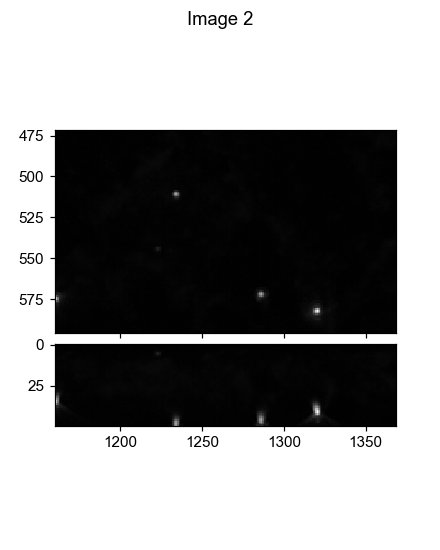

In [30]:
visual_tools.imshow_mark_3d_v2([fov.dapi_im, aire_im, aire_mask, dialated_mask])


In [7]:
_overwrite_image = False
#fov_ids = np.arange(37,40)
#_fov_id = 0
# bad fov 3, 28, 36
for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

    # generate the dialated mask
    # 2.0: create a seed mask from protein image Aire
    with h5py.File(fov.save_filename, "r", libver='latest') as _f:
        _grp = _f['protein']
        protein_ims = _grp['ims'][:]
        #protein_ids = _grp['ids'][:]
    aire_im = protein_ims[0]
    aire_mask = generate_analysis_mask(aire_im, snr_th=2.5)
    dialate_size = 5
    dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

    _overwrite_image = False
    _overwrite_spot = False
    # 2. Process image into candidate spots
    fov.parallel=True
    fov.combo_ref_id = 0
    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=True,
                                _fit_in_mask=True,
                                _fitting_args={'seed_mask':dialated_mask},
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=_overwrite_spot,
                                _verbose=True)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ base attributes loaded:['protein_ref_im'] in 2.780s.
+ loading correction from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile dire

C:\Users\puzheng\AppData\Local\Temp/ipykernel_43208/2420184002.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool)


-- folders not selected, allow processing all 26 folders
+ load reference image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_000.dax
- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_000.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_000.dax  in 10.058s
-- removing hot pixels for channels:['561'] in 10.538s
-- correct Z-shifts for channels:['561'] in 8.347s
-- illumination correction for channels: 561, in 3.322s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.843s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ base attributes saved:['combo_ref_im'] in 8.213s.
-- checking combo, region:[1 2] in 0.014s.
-- checking combo, region:[3 4] in 0.010s.
-- checking combo, region:[5 

++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'protein_ref_im', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi', 'verbose'] in 11.591s.
-- folders not selected, allow processing all 26 folders
-- checking protein, region:[2 1] in 0.014s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_002.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_002.hdf5 in 2.678s.
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_

++ base attributes loaded:['protein_ref_im'] in 2.899s.
+ loading correction from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5
++ base attributes loaded:[] in 0.011s.
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'paralle

 49 50] , finish in 1788.72s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_006.hdf5
++ base attributes loaded:['protein_ref_im'] in 2.789s.
+ loading correction from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_006.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_con

-- checking combo, region:[45 46] in 0.010s.
-- checking combo, region:[47 48] in 0.010s.
-- checking combo, region:[49 50] in 0.009s.
+ Start multi-processing of pre-processing for 25 images with 25 threads
++ processing combo ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] , finish in 1522.05s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading 

++ base attributes saved:['combo_ref_im'] in 7.866s.
-- checking combo, region:[1 2] in 0.013s.
-- checking combo, region:[3 4] in 0.008s.
-- checking combo, region:[5 6] in 0.008s.
-- checking combo, region:[7 8] in 0.008s.
-- checking combo, region:[ 9 10] in 0.008s.
-- checking combo, region:[11 12] in 0.008s.
-- checking combo, region:[13 14] in 0.009s.
-- checking combo, region:[15 16] in 0.049s.
-- checking combo, region:[17 18] in 0.008s.
-- checking combo, region:[19 20] in 0.008s.
-- checking combo, region:[21 22] in 0.008s.
-- checking combo, region:[23 24] in 0.008s.
-- checking combo, region:[25 26] in 0.008s.
-- checking combo, region:[27 28] in 0.008s.
-- checking combo, region:[29 30] in 0.008s.
-- checking combo, region:[31 32] in 0.008s.
-- checking combo, region:[33 34] in 0.007s.
-- checking combo, region:[35 36] in 0.008s.
-- checking combo, region:[37 38] in 0.008s.
-- checking combo, region:[39 40] in 0.008s.
-- checking combo, region:[41 42] in 0.007s.
-- checkin

- loading protein info from file:Conv_zscan_011.hdf5 in 2.743s.
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_011.hdf5
-- images and drifts already exist, skip.
in 4.24s.
-- folders not selected, allow processing all 26 folders
+ load reference image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_011.dax
- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_011.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_011.dax  in 9.770s
-- removing hot pixels for channels:['561'] in 9.511s
-- correct Z-shifts for channels:['561'] in 7.037s
-- illumination correction for channels: 561, in 2.714s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 30.761s
-- saving fov_info to file: J:\Pu_Temp\20210927-Th

++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'protein_ref_im', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi', 'verbose'] in 10.870s.
-- folders not selected, allow processing all 26 folders
-- checking protein, region:[2 1] in 0.012s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_013.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_013.hdf5 in 2.573s.
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_

++ base attributes loaded:['protein_ref_im'] in 2.898s.
+ loading correction from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_015.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_015.hdf5
++ base attributes loaded:[] in 0.011s.
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_015.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'paralle

+ Start multi-processing of pre-processing for 25 images with 25 threads
++ processing combo ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] , finish in 2549.12s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_017.hdf5
++ base attributes loaded:['protein_ref_im'] in 2

-- checking combo, region:[5 6] in 0.010s.
-- checking combo, region:[7 8] in 0.010s.
-- checking combo, region:[ 9 10] in 0.009s.
-- checking combo, region:[11 12] in 0.010s.
-- checking combo, region:[13 14] in 0.009s.
-- checking combo, region:[15 16] in 0.010s.
-- checking combo, region:[17 18] in 0.009s.
-- checking combo, region:[19 20] in 0.009s.
-- checking combo, region:[21 22] in 0.009s.
-- checking combo, region:[23 24] in 0.009s.
-- checking combo, region:[25 26] in 0.009s.
-- checking combo, region:[27 28] in 0.009s.
-- checking combo, region:[29 30] in 0.009s.
-- checking combo, region:[31 32] in 0.009s.
-- checking combo, region:[33 34] in 0.009s.
-- checking combo, region:[35 36] in 0.009s.
-- checking combo, region:[37 38] in 0.009s.
-- checking combo, region:[39 40] in 0.009s.
-- checking combo, region:[41 42] in 0.009s.
-- checking combo, region:[43 44] in 0.010s.
-- checking combo, region:[45 46] in 0.010s.
-- checking combo, region:[47 48] in 0.009s.
-- checking co

- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_020.hdf5
-- images and drifts already exist, skip.
in 4.08s.
-- folders not selected, allow processing all 26 folders
+ load reference image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
- correct the whole fov for image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax  in 11.014s
-- removing hot pixels for channels:['561'] in 9.282s
-- correct Z-shifts for channels:['561'] in 8.295s
-- illumination correction for channels: 561, in 2.827s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 32.431s
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_020.hdf5
++ base attributes 

++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'protein_ref_im', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi', 'verbose'] in 11.642s.
-- folders not selected, allow processing all 26 folders
-- checking protein, region:[2 1] in 0.010s.
+ Start sequential pre-processing for 1 images
++ processed protein ids: [1 2] + batch process image: R:\Pu_Aire\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_022.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_022.hdf5 in 2.700s.
- writting protein info to file:J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_

++ base attributes loaded:['protein_ref_im'] in 2.780s.
+ loading correction from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ base attributes loaded:[] in 0.009s.
-- saving fov_info to file: J:\Pu_Temp\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'paralle

ValueError: not enough values to unpack (expected 3, got 0)

In [ ]:
fov._process_image_to_spots

In [15]:
from scipy.ndimage import gaussian_filter
from scipy.stats import scoreatpercentile

In [13]:
from scipy.ndimage import gaussian_filter
from scipy.stats import scoreatpercentile
_aire_im = aire_im.copy()
_gaussian_size=5
_normed_aire_im = _aire_im / np.max(_aire_im)
_normed_aire_im = gaussian_filter(_normed_aire_im, _gaussian_size)

In [ ]:
_normalize_per = 1

In [16]:
scoreatpercentile(_aire_im, 1), scoreatpercentile(_aire_im, 99)

(0.0, 439.0)

In [ ]:
_vmin, _vmax = scoreatpercentile(_aire_im, 1) scoreatpercentile(_aire_im, 99)
_normed_aire_im = 

<IPython.core.display.Javascript object>


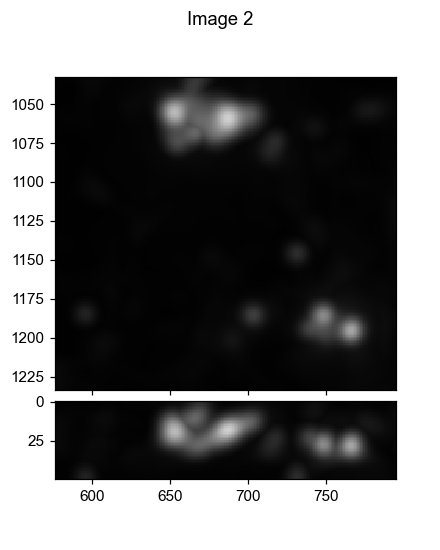

In [14]:
#aire_mask = generate_analysis_mask(aire_im, snr_th=5)
visual_tools.imshow_mark_3d_v2([aire_im, _normed_aire_im])

In [ ]:
# 2.0: create a seed mask from combo image Aire
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][12:14]
    combo_ids = _grp['ids'][12:14]


In [49]:
combo_ids

array([13, 14])

<IPython.core.display.Javascript object>


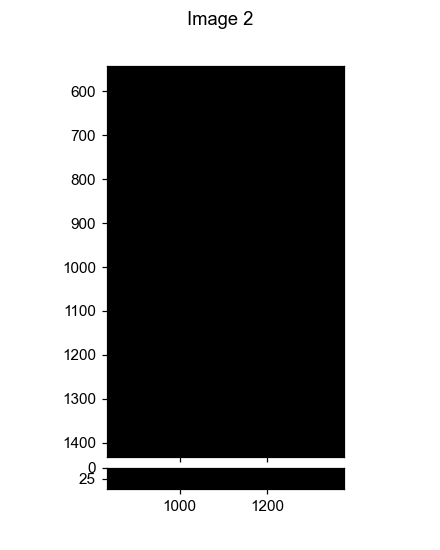

In [50]:
visual_tools.imshow_mark_3d_v2(combo_ims)

<IPython.core.display.Javascript object>


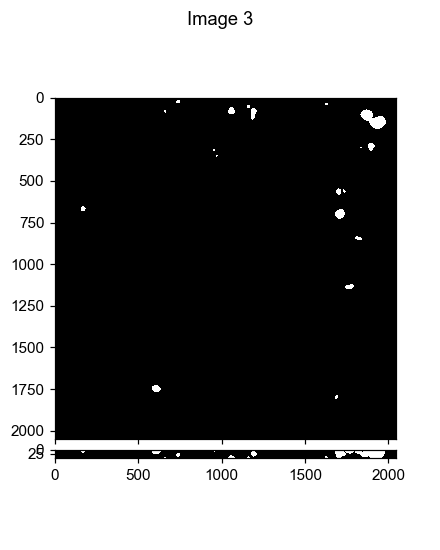

In [13]:
visual_tools.imshow_mark_3d_v2([aire_im, aire_mask, dialated_mask])

In [23]:
_overwrite_image = False
_overwrite_spot = False
# 2. Process image into candidate spots
fov.parallel=True
fov.combo_ref_id = 0
fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _fit_in_mask=True,
                            _fitting_args={'seed_mask':dialated_mask},
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=_overwrite_spot,
                            _verbose=True)


-- No folder selected, allow processing all 26 folders
-- checking combo, region:[1 2] in 0.004s.
-- checking combo, region:[3 4] in 0.003s.
-- checking combo, region:[5 6] in 0.003s.
-- checking combo, region:[7 8] in 0.003s.
-- checking combo, region:[ 9 10] in 0.003s.
-- checking combo, region:[11 12] in 0.003s.
-- checking combo, region:[13 14] in 0.003s.
-- checking combo, region:[15 16] in 0.003s.
-- checking combo, region:[17 18] in 0.003s.
-- checking combo, region:[19 20] in 0.003s.
-- checking combo, region:[21 22] in 0.003s.
-- checking combo, region:[23 24] in 0.003s.
-- checking combo, region:[25 26] in 0.003s.
-- checking combo, region:[27 28] in 0.003s.
-- checking combo, region:[29 30] in 0.003s.
-- checking combo, region:[31 32] in 0.003s.
-- checking combo, region:[33 34] in 0.003s.
-- checking combo, region:[35 36] in 0.003s.
-- checking combo, region:[37 38] in 0.003s.
-- checking combo, region:[39 40] in 0.003s.
-- checking combo, region:[41 42] in 0.003s.
-- check

In [33]:
fov._load_from_file('combo', _overwrite=True)

+ loading combo from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_003.hdf5
++ finish loading combo in 0.009s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1630: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


<IPython.core.display.Javascript object>


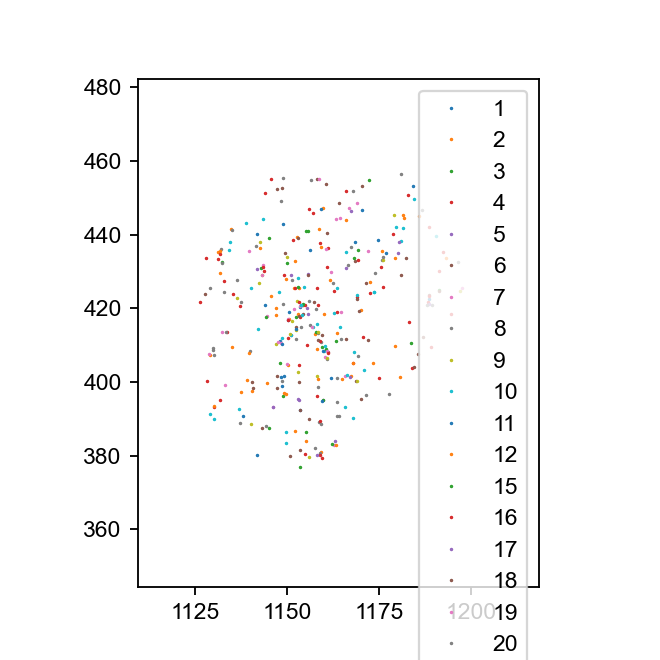

In [34]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
for _id, _spots in zip(fov.combo_ids, fov.combo_spots_list):
    if len(_spots) > 0:
        _sel_spots = _spots[(_spots[:,1] > 25) * (_spots[:,1] <= 35)]
        
        ax.plot(_sel_spots[:,2], _sel_spots[:,3], '.', markersize=1, label=f'{_id}')

ax.set_aspect('equal', 'box')
ax.legend()
plt.show()


In [27]:
# search pairs
zxys_list = [_spots[:,1:4]*fov.shared_parameters['distance_zxy'] for _spots in fov.combo_spots_list]

In [14]:


for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 2. Process image into candidate spots
    fov.combo_ref_id = 0
    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

    # 4. load dapi image
    dapi_im = fov._load_dapi_image(_dapi_id=0)

    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loadi

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_011.dax  in 24.018s
-- removing hot pixels for channels:['561'] in 10.692s
-- correct Z-shifts for channels:['561'] in 8.531s
-- illumination correction for channels: 561, in 3.612s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 48.001s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_011.hdf5
++ base attributes saved:['combo_ref_im'] in 8.597s.
-- checking combo, region:[1 2] in 0.006s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.005s.
us

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_012.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_012.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_012.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522

-- removing hot pixels for channels:['561'] in 10.147s
-- correct Z-shifts for channels:['561'] in 8.285s
-- illumination correction for channels: 561, in 3.160s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 47.999s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_013.hdf5
++ base attributes saved:['combo_ref_im'] in 8.117s.
-- checking combo, region:[1 2] in 0.004s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.004s.
used_channels: ['750', '647', '561']
-- checking c

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_014.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'co

-- illumination correction for channels: 561, in 2.646s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 38.472s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
++ base attributes saved:['protein_ref_im'] in 7.865s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['

++ base attributes saved:['combo_ref_im'] in 8.104s.
-- checking combo, region:[1 2] in 0.005s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[15 16] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[17 18] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[19 20] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[21 22] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[23 24] in 0.004s.
u

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_016.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

++ processed protein ids: [1 2] + batch process image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_016.hdf5 in 0.613s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax  in 21.912s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 42.538s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 31.094s
-- bleedthrough correction for channels: ['750', '647'] in 11.635s
-- illumination correction for channels: 750, 647, 488, 561, in 12.403s
-- apply bead_drift calculate for channel: 561
-- start a

 49 50] , finish in 406.48s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_017.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_017.dax  in 10.677s
-- removing hot pixels for channels:['405'] in 13.130s
-- correct Z-shifts for channels:['405'] in 8.995s
-- illumination correction for channels: 405, in 3.841s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 37.814s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_017.hdf5
++ base attributes saved:['dapi_im'] in 7.940s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
--- combo attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
save type: protein"
-- saving protein to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
--- protein attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_018.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_018.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x20

-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.561s
-- update drift of H25P1\Conv_zscan_018.dax into file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\drift\Conv_zscan_018_current_cor.pkl
in 372.80s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ loa

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax  in 11.713s
-- removing hot pixels for channels:['405'] in 12.981s
-- correct Z-shifts for channels:['405'] in 7.459s
-- illumination correction for channels: 405, in 2.693s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 35.861s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5
++ base attributes saved:['dapi_im'] in 7.885s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_W

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax  in 6.910s
-- removing hot pixels for channels:['561'] in 10.092s
-- correct Z-shifts for channels:['561'] in 8.006s
-- illumination correction for channels: 561, in 2.957s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 28.851s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_020.hdf5
++ base attributes saved:['combo_ref_im'] in 7.991s.
-- checking combo, region:[1 2] in 0.004s.
used_ch

dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_021.dax  in 16.525s
-- removing hot pixels for channels:['561'] in 9.145s
-- correct Z-shifts for channels:['561'] in 7.272s
-- illumination correction for channels: 561, in 2.673s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 36.845s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_021.hdf5
++ base attributes saved:['protein_ref_im'] in 7.832s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_023.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'co

-- illumination correction for channels: 561, in 2.928s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 23.895s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
++ base attributes saved:['protein_ref_im'] in 7.650s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['

-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ base attributes saved:['combo_ref_im'] in 7.558s.
-- checking combo, region:[1 2] in 0.004s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[15 16] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[17 18] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[19 20] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[21

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_025.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

- loading protein info from file:Conv_zscan_025.hdf5 in 0.596s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_025.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_025.dax  in 8.661s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 41.958s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 30.642s
-- bleedthrough correction for channels: ['750', '647'] in 10.546s
-- illumination correction for channels: 750, 647, 488, 561, in 11.693s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
--- align image 0 in 8.050s.
--- align image 1 in 7.978s.
--- align image 2 in 8.123s.
--- drifts for crops:[0 1 2] pass th

 49 50] , finish in 387.96s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_026.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_026.dax  in 7.437s
-- removing hot pixels for channels:['405'] in 12.026s
-- correct Z-shifts for channels:['405'] in 8.881s
-- illumination correction for channels: 405, in 4.045s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.358s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_026.hdf5
++ base attributes saved:['dapi_im'] in 8.079s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5
--- combo attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
save type: protein"
-- saving protein to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5
--- protein attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_027.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_027.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x20

-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.868s
-- update drift of H25P1\Conv_zscan_027.dax into file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\drift\Conv_zscan_027_current_cor.pkl
in 369.30s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ loa

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax  in 5.571s
-- removing hot pixels for channels:['561'] in 9.166s
-- correct Z-shifts for channels:['561'] in 7.119s
-- illumination correction for channels: 561, in 2.703s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 25.440s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5
++ base attributes saved:['combo_ref_im'] in 8.069s.
-- checking combo, region:[1 2] in 0.004s.
used_cha

In [9]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]

In [10]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['protein']
    protein_ims = _grp['ims'][:]
    protein_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


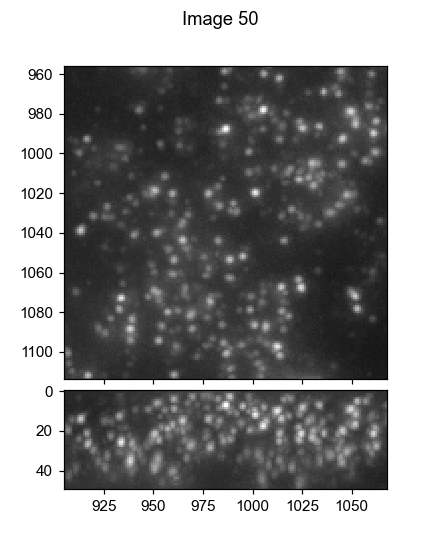

In [11]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([protein_ims[0]]+list(combo_ims))
